# Models

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LassoLarsCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv('./data_prepared.csv')

In [3]:
# Split into train/test
X = df.drop('Rating', axis=1)
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Encode categorical features and normalize numerical features.

In [4]:
encoders = ['CatBoostEncoder', 'GLMMEncoder', 'JamesSteinEncoder', 
            'LeaveOneOutEncoder', 'MEstimateEncoder', 'TargetEncoder', 
            'BinaryEncoder', 'HashingEncoder', 'OrdinalEncoder']

class CatEncoder(TransformerMixin):
    def __init__(self, enc_name='MEstimateEncoder', **kwargs):
        exec('from category_encoders import %s' % enc_name)
        exec('self.encoder = %s(**kwargs)' % enc_name)
    
    def fit(self, X, y=None):
        return self.encoder.fit(X, y)
    
    def transform(self, X, y=None):
        return self.encoder.transform(X, y)
    
    def set_params(self, **params):
        print(params)
        return self.encoder.set_params(**params)

In [5]:
num_columns = ['Review Date', 'Cocoa Percent']
cat_columns = df.select_dtypes(exclude='number').columns.tolist()

# Categorical encoding
#cat_enc = CatEncoder()
#cat_enc.fit(X_train, y_train)

#X_train_trans = cat_enc.transform(X_train, y_train)
#X_test_trans = cat_enc.transform(X_test, y_test)

# Normalize numerical columns
num_enc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns)],
    remainder='passthrough')
#num_enc.fit(X_train_trans)

In [6]:
# Utility function for evaluation
def eval_mod(model):
    y_pred = model.predict(X_test)
    
    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('MAE:', mean_absolute_error(y_test, y_pred))
    print('R^2:', r2_score(y_test, y_pred))

# Evaluate encoders
def eval_encoders(model):
    scores = []
    for enc in encoders:
        pipeline = Pipeline([('cat_enc', CatEncoder(enc)), 
                             ('scaler', num_enc), 
                             ('mod', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(rmse)
    
    return pd.Series(scores, index=encoders).sort_values()

In [7]:
feature_names = X_train.columns

## PCA

In [8]:
from sklearn.decomposition import PCA

pca = Pipeline([('cat_enc',CatEncoder('CatBoostEncoder')), 
                   ('scaler', num_enc), 
                   ('pca', PCA(n_components=3))])
pca.fit(X_train, y_train)

Pipeline(steps=[('cat_enc', <__main__.CatEncoder object at 0x000001C6C9282248>),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('pca', PCA(n_components=3))])

In [10]:
X_pca = pd.DataFrame(pca.transform(X_train))
#sns.scatterplot(x=0, y=1, data=X_pca);

<IPython.core.display.Javascript object>


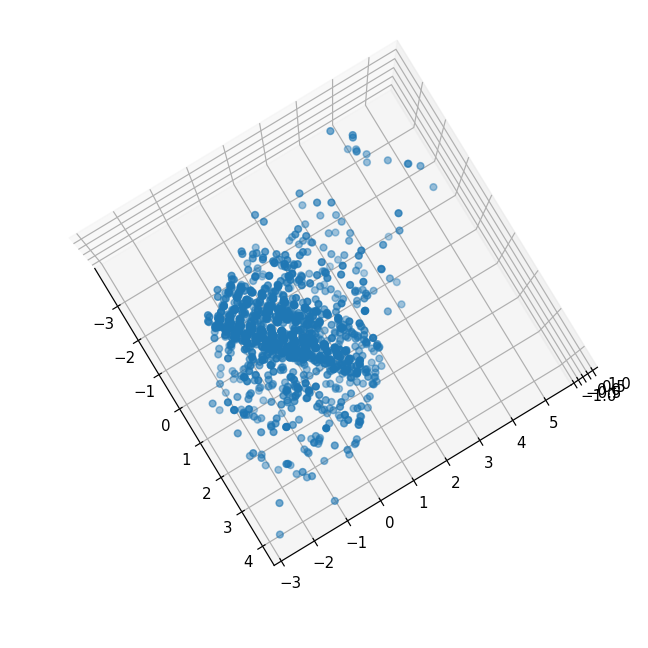

In [11]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig)
x = X_pca[0]
y = X_pca[1]
z = X_pca[2]

ax.scatter(x, y, z)
plt.show()

## Linear regression

In [78]:
eval_encoders(LinearRegression())

CatBoostEncoder       0.406369
LeaveOneOutEncoder    0.406429
TargetEncoder         0.406792
HashingEncoder        0.406811
OrdinalEncoder        0.408809
BinaryEncoder         0.411075
JamesSteinEncoder     0.422154
GLMMEncoder           0.423193
MEstimateEncoder      0.431460
dtype: float64

In [70]:
lr_mod = Pipeline([('cat_enc',CatEncoder('CatBoostEncoder')), 
                   ('scaler', num_enc), 
                   ('lr', LinearRegression())])
lr_mod.fit(X_train, y_train)

Pipeline(steps=[('cat_enc', <__main__.CatEncoder object at 0x0000020935811748>),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('lr', LinearRegression())])

In [71]:
eval_mod(lr_mod)

RMSE: 0.40636909151071005
MAE: 0.3155722490041258
R^2: 0.2400164615801822


In [72]:
coefs = pd.DataFrame({'feature': feature_names, 'coef': lr_mod['lr'].coef_})
coefs['abs_coef'] = np.abs(coefs['coef'])
coefs.sort_values('abs_coef', ascending=False).drop('abs_coef', axis=1)

,feature,coef
4,Cocoa Percent,0.650457
7,Continent_origin,0.637516
10,Company,0.485254
9,Manufacturer,0.464666
3,Specific Bean Origin or Bar Name,0.254839
27,rubbery,-0.211428
23,pungent,-0.210102
28,hammy,-0.183995
24,dirty,-0.181694
6,Sub-region_company,0.176973


### Lasso regression

In [79]:
eval_encoders(LassoCV(max_iter=2000))

HashingEncoder        0.406842
CatBoostEncoder       0.407948
LeaveOneOutEncoder    0.408213
TargetEncoder         0.408626
BinaryEncoder         0.409286
JamesSteinEncoder     0.423276
GLMMEncoder           0.423418
MEstimateEncoder      0.433513
OrdinalEncoder        0.434596
dtype: float64

In [81]:
lasso_mod = Pipeline([('cat_enc',CatEncoder('HashingEncoder')), 
                    ('scaler', num_enc), 
                    ('lasso', LassoCV(max_iter=2000))])

lasso_mod.fit(X_train, y_train)

Pipeline(steps=[('cat_enc', <__main__.CatEncoder object at 0x0000020935307A08>),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('lasso', LassoCV(max_iter=2000))])

In [82]:
lasso_mod['lasso'].alpha_

0.0001782898167526528

In [83]:
eval_mod(lasso_mod)

RMSE: 0.40684179554171135
MAE: 0.3212007056804827
R^2: 0.23824734953555482


In [84]:
coefs = pd.DataFrame({'feature': feature_names, 'coef': lasso_mod['lasso'].coef_})
coefs['abs_coef'] = np.abs(coefs['coef'])
coefs.sort_values('abs_coef', ascending=False).drop('abs_coef', axis=1)

ValueError: arrays must all be same length

### Ridge regression

In [80]:
eval_encoders(RidgeCV(alphas=np.logspace(-2, 2, num=5)))

CatBoostEncoder       0.405092
TargetEncoder         0.406194
LeaveOneOutEncoder    0.406605
HashingEncoder        0.406889
OrdinalEncoder        0.408863
BinaryEncoder         0.411557
JamesSteinEncoder     0.420482
GLMMEncoder           0.423140
MEstimateEncoder      0.429692
dtype: float64

In [85]:
ridge_mod = Pipeline([('cat_enc',CatEncoder('CatBoostEncoder')), 
                    ('scaler', num_enc), 
                    ('ridge', RidgeCV(alphas=np.logspace(-2, 2, num=5)))])

ridge_mod.fit(X_train, y_train)

Pipeline(steps=[('cat_enc', <__main__.CatEncoder object at 0x0000020935880E08>),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('ridge',
                 RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])))])

In [86]:
ridge_mod['ridge'].alpha_

10.0

In [87]:
eval_mod(ridge_mod)

RMSE: 0.40509218512814593
MAE: 0.31521091009237906
R^2: 0.2447850485416425


### Feature importance

In [52]:
pi = permutation_importance(lr_mod, X_train, y_train, 
                            n_repeats=10, random_state=42)

In [53]:
perm_sorted_idx = (-pi.importances_mean).argsort()

In [54]:
importances = pd.DataFrame(pi.importances[perm_sorted_idx].T, columns=feature_names[perm_sorted_idx])
importances.iloc[:, :3]

,Company,Manufacturer,Specific Bean Origin or Bar Name
0,0.125105,0.119416,0.078776
1,0.083690,0.077070,0.071739
2,0.112418,0.102213,0.064858
3,0.118817,0.108759,0.061722
4,0.100641,0.092273,0.068414
5,0.106091,0.097739,0.070817
6,0.108432,0.098974,0.076222
7,0.109429,0.102258,0.071143
8,0.109787,0.104547,0.062118
9,0.110567,0.099620,0.078315


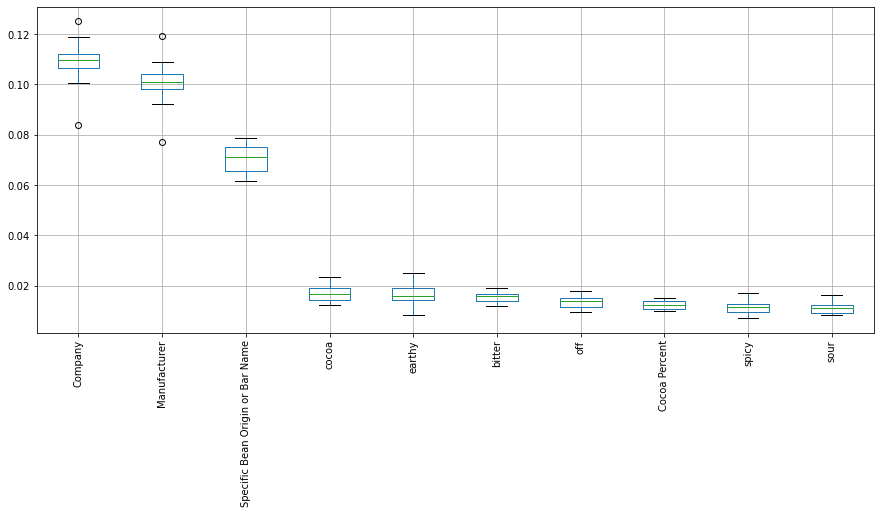

In [55]:
fig, ax = plt.subplots(figsize=(15, 6))
importances.iloc[:, :10].boxplot()
plt.xticks(rotation=90);

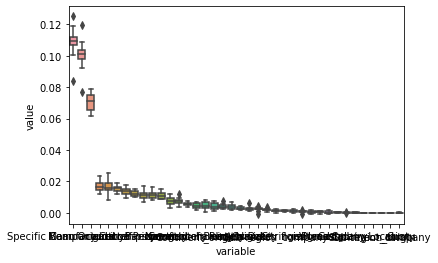

In [56]:
sns.boxplot(x="variable", y="value", data=pd.melt(importances));

In [57]:
importances = pd.DataFrame({'feature': feature_names, 
                            'importances_mean': pi.importances_mean, 
                            'importances_std': pi.importances_std})
importances.sort_values('importances_mean', ascending=False)[:15]

,feature,importances_mean,importances_std
10,Company,0.108498,0.010428
9,Manufacturer,0.100287,0.010370
3,Specific Bean Origin or Bar Name,0.070412,0.005897
16,cocoa,0.016952,0.003560
17,earthy,0.016918,0.004675
31,bitter,0.015323,0.002204
30,off,0.013574,0.002423
4,Cocoa Percent,0.012363,0.001845
15,spicy,0.011369,0.002693
19,sour,0.011280,0.002380


## SVM

In [88]:
eval_encoders(SVR())

GLMMEncoder           0.396141
CatBoostEncoder       0.401887
TargetEncoder         0.402645
LeaveOneOutEncoder    0.403652
BinaryEncoder         0.406927
HashingEncoder        0.413892
MEstimateEncoder      0.414953
JamesSteinEncoder     0.420034
OrdinalEncoder        0.480944
dtype: float64

In [58]:
svr_mod = Pipeline([('cat_enc', CatEncoder('GLMMEncoder')), 
                   ('scaler', num_enc), 
                   ('svr', SVR())])
svr_mod.fit(X_train, y_train)

Pipeline(steps=[('cat_enc', <__main__.CatEncoder object at 0x0000020935307C08>),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('svr', SVR())])

In [59]:
eval_mod(svr_mod)

RMSE: 0.3961410508340308
MAE: 0.3128589969084083
R^2: 0.2777915792362641


In [168]:
params = {'svr__kernel': ['rbf', 'linear', 'poly'], 
          'svr__C': [0.03, 0.1, 0.3, 1, 3], 
          'svr__epsilon': [0.03, 0.1, 0.3, 1]}

gs = GridSearchCV(svr_mod, params, 
                  cv=5, 
                  scoring='neg_root_mean_squared_error', 
                  return_train_score=True,
                  n_jobs=-1,
                  verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cat_enc',
                                        <__main__.CatEncoder object at 0x0000022BAC632FC8>),
                                       ('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Review '
                                                                          'Date',
                                                                          'Cocoa '
                                                                          'Percent'])])),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.03, 0.1, 0.3, 1, 3],
                         'svr__epsilon': [0.03, 0.1, 0

In [169]:
# Show best parameters
gs.best_params_

{'svr__C': 0.1, 'svr__epsilon': 0.03, 'svr__kernel': 'rbf'}

In [170]:
# Compare the train and test scores
results = pd.DataFrame(gs.cv_results_)
results.loc[results['mean_test_score'] == gs.best_score_, ['mean_train_score', 'mean_test_score']]

,mean_train_score,mean_test_score
12,-0.293435,-0.376526


In [171]:
svr_best_mod = gs.best_estimator_

In [21]:
eval_mod(svr_best_mod)

RMSE: 0.46782851577565016
MAE: 0.38060698847423813
R^2: -0.007247572467334429


In [8]:
eval_encoders(SVR(C=0.3, epsilon=0.03))

GLMMEncoder           0.388660
CatBoostEncoder       0.401977
TargetEncoder         0.402894
LeaveOneOutEncoder    0.405017
MEstimateEncoder      0.407155
BinaryEncoder         0.412357
HashingEncoder        0.416556
JamesSteinEncoder     0.431125
OrdinalEncoder        0.470190
dtype: float64

## Random Forest

In [10]:
eval_encoders(RandomForestRegressor(random_state=42, max_depth=7))

BinaryEncoder         0.410112
HashingEncoder        0.410256
OrdinalEncoder        0.416301
LeaveOneOutEncoder    0.416642
TargetEncoder         0.417682
CatBoostEncoder       0.418458
GLMMEncoder           0.441413
MEstimateEncoder      0.443260
JamesSteinEncoder     0.446120
dtype: float64

In [49]:
rf_mod = Pipeline([('cat_enc', CatEncoder('BinaryEncoder')), 
                   ('scaler', num_enc), 
                   ('rf', RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=200))])

params = {'rf__max_depth': [21, 22, 23], 
          'rf__min_samples_split': [12, 15, 17], 
          'rf__min_samples_leaf': [2, 3, 4], 
          'rf__max_leaf_nodes': [None, 120, 150], 
          'rf__min_impurity_decrease': [0, 1e-7], 
          'rf__max_features': ['auto', 'sqrt']}

gs = GridSearchCV(rf_mod, params, 
                  cv=5, 
                  scoring='neg_root_mean_squared_error', 
                  return_train_score=True,
                  n_jobs=-1,
                  verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 18.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cat_enc',
                                        <__main__.CatEncoder object at 0x00000173D46A2148>),
                                       ('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Review '
                                                                          'Date',
                                                                          'Cocoa '
                                                                          'Percent'])])),
                                       ('rf',
                                        RandomForestRegressor(n_estimators=200,
                                                              n_jobs

In [50]:
# Show best parameters
gs.best_params_

{'rf__max_depth': 21,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': 150,
 'rf__min_impurity_decrease': 0,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 12}

In [51]:
# Compare the train and test scores
results = pd.DataFrame(gs.cv_results_)
results.loc[results['mean_test_score'] == gs.best_score_, ['mean_train_score', 'mean_test_score']]

,mean_train_score,mean_test_score
36,-0.255739,-0.387597
45,-0.255739,-0.387597


In [52]:
rf_best_mod = gs.best_estimator_

In [53]:
eval_mod(rf_best_mod)

RMSE: 0.4005372177559178
MAE: 0.31954335192500866
R^2: 0.2616732510462646


In [54]:
(rf_best_mod['rf'].estimators_[0].tree_.children_left<0).sum()

150

In [44]:
import sklearn
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 